In [ ]:
from Modelos import Gerador, GeradorClassificador, cria_classificadores
from Preprocessamento import preprocessamento_dataframe, dividir_em_batches
from segmentandoDatasets import *
from visualizacao import plot_batch
import itertools
from tensorflow.keras.utils import Sequence
import tensorflow as tf


In [ ]:
#segmentacao_PKLot(imagens_treino=1024, dias_treino=5, imagens_validacao=64, dias_validaco=1, imagens_teste=20000, dias_teste=2, faculdades=["PUC"])
val, _ = preprocessamento_dataframe(caminho_csv='CSV/PUC_Segmentado_Validacao.csv', autoencoder=False, data_algumentantation=False)
teste, teste_df = preprocessamento_dataframe(caminho_csv='CSV/PUC_Segmentado_Teste.csv', autoencoder=False, data_algumentantation=False)

In [ ]:
dividir_em_batches('CSV/PUC_Segmentado_Treino.csv', n_batches=16)

In [ ]:
batch, _ = preprocessamento_dataframe('CSV/batch_0.csv', False)


Epoch 2: val_loss did not improve from 0.54253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7656 - loss: 0.5517 - val_accuracy: 0.8750 - val_loss: 0.4614
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8125 - loss: 0.4875
Epoch 3: val_loss did not improve from 0.54253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8125 - loss: 0.4875 - val_accuracy: 0.7969 - val_loss: 0.4355
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8438 - loss: 0.4196
Epoch 4: val_loss did not improve from 0.54253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8438 - loss: 0.4196 - val_accuracy: 0.7812 - val_loss: 0.4398
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8750 - loss: 0.3535
Epoch 5: val_loss did not improve from 0.54253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8750 - loss: 0.3535 - val_accuracy: 0.7812 - val_loss: 0.4396
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8594 - loss: 0.3226
Epoch 6: val_loss did n

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
[1 0 1 ... 1 0 0]


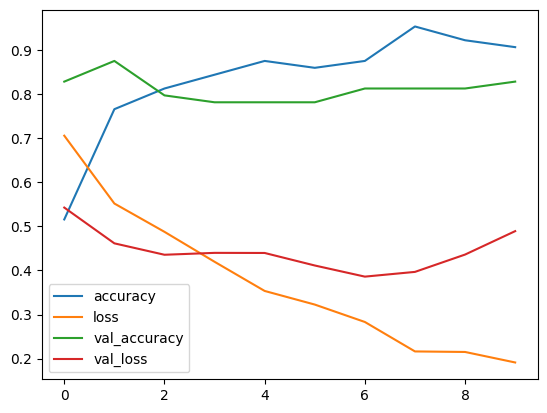

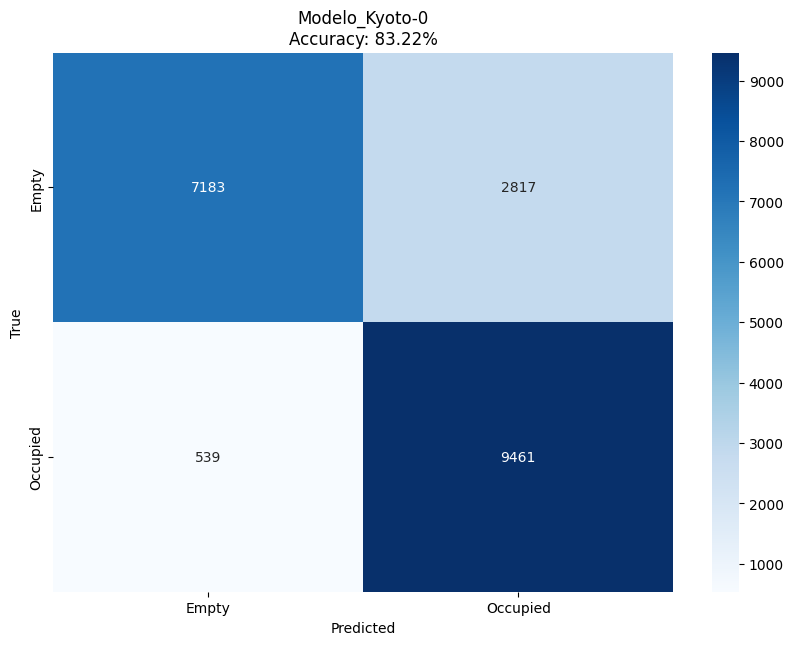

In [5]:
cria_classificadores(n_modelos=1, nome_modelo='Modelo_Kyoto', base_usada='Kyoto', treino=batch, validacao=val, teste=teste, teste_csv=teste_df)

In [6]:
batch1, _ = preprocessamento_dataframe('CSV/batch_1.csv', False)


class CombinedGenerator(Sequence):
    def __init__(self, generator1, generator2):
        self.generator1 = generator1
        self.generator2 = generator2
        self.batch_size = generator1.batch_size  
        self.n_samples = len(generator1) + len(generator2)  
        print("Total de imagens: " , self.get_total_images())

    def __len__(self):
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, idx):
        if idx < len(self.generator1):
            return self.generator1[idx]
        else:
            return self.generator2[idx - len(self.generator1)]
    
    def get_total_images(self):
        return len(self.generator1) * self.generator1.batch_size + len(self.generator2) * self.generator2.batch_size



combined_generator = CombinedGenerator(batch, batch1)


Found 64 validated image filenames belonging to 2 classes.
Imagens totais: 64
Total de imagens:  128


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 1849)           │     7,576,745 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 3)      │     7,581,299 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,158,044 (57.82 MB)

 Trainable params: 15,158,044 (57.82 MB)

 Non-trainable params: 0 (0.00 B)

Pesos carregados com sucesso
Epoch 1/10


/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:591: UserWarning: A total of 3 objects could not be loaded. Example error message for object <Dense name=dense, built=True>:

Layer 'dense' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=dense, built=True>, <Dense name=dense_1, built=True>, <Dense name=dense_2, built=True>]
  warnings.warn(msg)
/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3438 - loss: 0.7718
Epoch 1: val_loss improved from -inf to 0.62374, saving model to Pesos_parciais/weights-improvement-01-0.62.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3438 - loss: 0.7718 - val_accuracy: 0.7969 - val_loss: 0.6237
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6406 - loss: 0.6044
Epoch 2: val_loss did not improve from 0.62374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6406 - loss: 0.6044 - val_accuracy: 0.8281 - val_loss: 0.5445
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8281 - loss: 0.5118
Epoch 3: val_loss did not improve from 0.62374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8281 - loss: 0.5118 - val_accuracy: 0.7969 - val_loss: 0.4939
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8906 - loss: 0.4606
Epoch 4: val_loss did not improve from 0.62374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8906 - loss: 0.4606 - val_acc

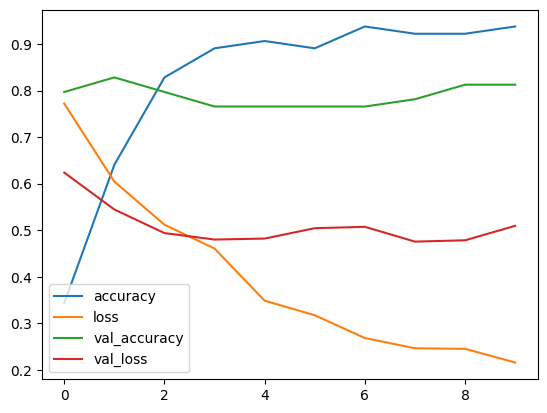

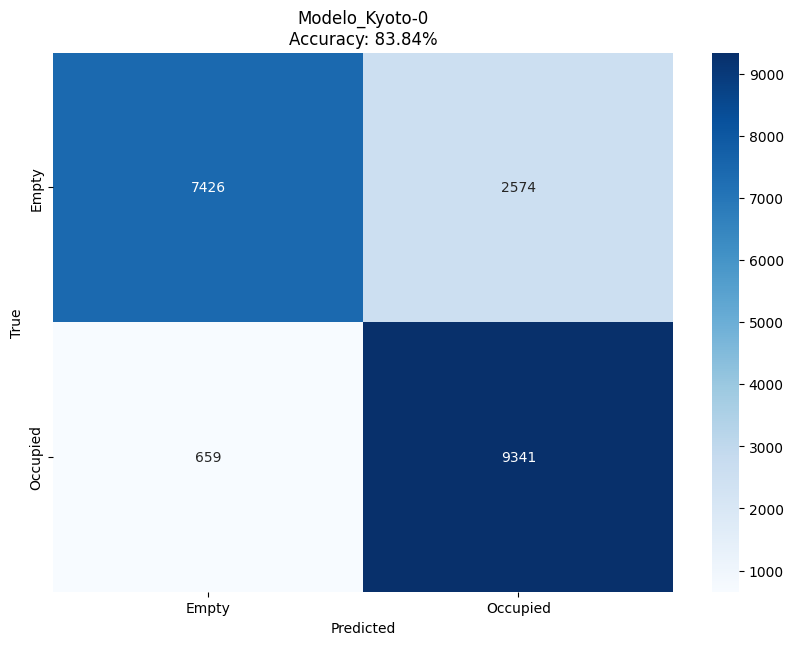

In [7]:
cria_classificadores(n_modelos=1, nome_modelo='Modelo_Kyoto', base_usada='Kyoto', treino=combined_generator, validacao=val, teste=teste, teste_csv=teste_df)

In [8]:
batch2, _ = preprocessamento_dataframe('CSV/batch_2.csv', False)

combined_generator2 = CombinedGenerator(combined_generator, batch2)


Found 64 validated image filenames belonging to 2 classes.
Imagens totais: 64
Total de imagens:  128


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 1849)           │     7,576,745 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 3)      │     7,581,299 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,158,044 (57.82 MB)

 Trainable params: 15,158,044 (57.82 MB)

 Non-trainable params: 0 (0.00 B)

Pesos carregados com sucesso
Epoch 1/10


/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:591: UserWarning: A total of 3 objects could not be loaded. Example error message for object <Dense name=dense, built=True>:

Layer 'dense' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=dense, built=True>, <Dense name=dense_1, built=True>, <Dense name=dense_2, built=True>]
  warnings.warn(msg)
/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4844 - loss: 0.6900
Epoch 1: val_loss improved from -inf to 0.54870, saving model to Pesos_parciais/weights-improvement-01-0.55.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4844 - loss: 0.6900 - val_accuracy: 0.8125 - val_loss: 0.5487
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8438 - loss: 0.5390
Epoch 2: val_loss did not improve from 0.54870
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8438 - loss: 0.5390 - val_accuracy: 0.7500 - val_loss: 0.5159
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9062 - loss: 0.4123
Epoch 3: val_loss did not improve from 0.54870
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9062 - loss: 0.4123 - val_accuracy: 0.7500 - val_loss: 0.5086
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8281 - loss: 0.3722
Epoch 4: val_loss did not improve from 0.54870
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8281 - loss: 0.3722 - val_acc

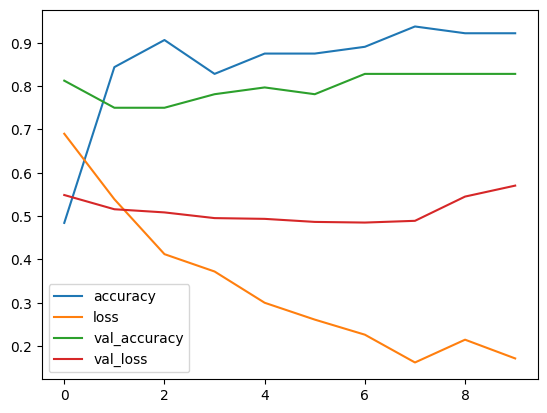

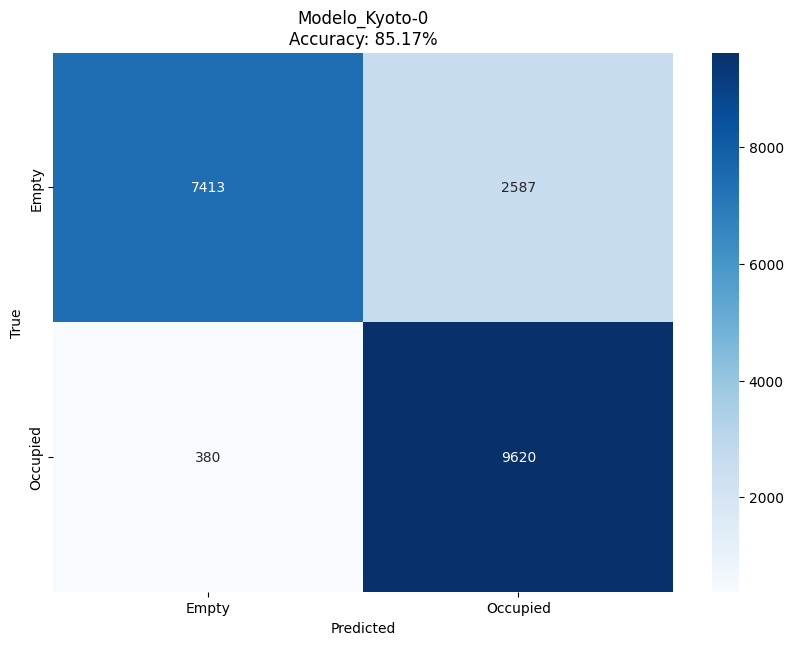

In [9]:
cria_classificadores(n_modelos=1, nome_modelo='Modelo_Kyoto', base_usada='Kyoto', treino=combined_generator2, validacao=val, teste=teste, teste_csv=teste_df)